## Desarrollo de un Algoritmo de Aprendizaje por Refuerzo Profundo para la Gestión del TI

Instalación e importación de librerias

In [1]:
!pip install gym pandas numpy keras tensorflow==2.10.0

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from collections import deque
import random
import gym
from gym import spaces
import time
import matplotlib.pyplot as plt
import gc

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
# Cargar el dataset desde un archivo CSV
data = pd.read_csv('C:/Users/NUDIA/Documents/proyecto/network_metric.csv')

# Parámetros de red
X = data[['bandwidth', 'congestion_index', 'error_rate', 'num_segments']]

# División de los datos
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)

# Transformación de los datos
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Primeros 5 elementos
print(X.head())

   bandwidth  congestion_index  error_rate  num_segments
0        423          0.854846    0.206854             7
1        322          0.031056    0.180614            10
2        419          0.933174    0.258196             5
3        188          0.053191    0.298611            10
4        246          0.040650    0.477639            10


Definición del entorno

In [5]:
class TactileInternetEnv(gym.Env):
    def __init__(self, data):
        super(TactileInternetEnv, self).__init__()
        self.data = np.array(data, dtype=np.float32)
        self.current_step = 0
        self.state = None
        self.packets_sent = 0
        self.packets_lost = 0
        
        # Parámetros de codificación RLNC (Random Linear Network Coding)
        self.coefficients = 3
        self.generation_size = 3 

        # Rango de normalización para cada parámetro
        self.num_segments_range = (1, 10)  # Número de segmentos (1 a 10)
        self.error_rate_range = (0, 0.5)   # Tasa de error (0% a 50%)
        self.bandwidth_range = (100, 500)  # Ancho de banda (100 Mbps a 500 Mbps)
        self.cong_index_range = (0, 1) 

        self.action_space = spaces.Discrete(5)  # acciones: aumentar, reducir, mantener
        self.observation_space = spaces.Box(low=0, high=1, shape=(data.shape[1],), dtype=np.float32)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.received_packets = []  
        self.decoded = False
        self.state = self.data[self.current_step]
        return self.state

    def desnormalize(self, value, value_range):
        # Convierte un valor normalizado [0,1] a su escala original
        return value_range[0] + value * (value_range[1] - value_range[0])

    def rlnc_encode(self, data, num_coefficients):      
        # Codifica los datos usando RLNC 
        coefficients = np.random.rand(num_coefficients) 
        coefficients = coefficients / np.sum(coefficients)  
        encoded_packet = np.sum([c * d for c, d in zip(coefficients, data)], axis=0) 
        return coefficients, encoded_packet  # Devuelve los coeficientes y el paquete codificado

    def rlnc_decode(self):
        # Intenta reconstruir los datos originales resolviendo un sistema lineal
        if len(self.received_packets) < self.generation_size: 
            return False 
        try:
            A = []
            b = []
            for coeffs, packet in self.received_packets[:self.generation_size]:
                A.append(coeffs)   
                b.append(packet[0]) 
                
            A = np.array(A)   
            b = np.array(b)  
            decoded = np.linalg.solve(A, b) 
            return True  
        except np.linalg.LinAlgError:
            return False
    
    def simulate_lost_packet(self, cong_index, rate_bd):
        # Simula la pérdida de paquetes
        self.packets_sent += 1
        probability_loss = 0.8 
        if probability_loss < random.random() and cong_index > rate_bd :
            self.packets_lost += 1
            return False
        return True

    def simulate_packet_transfer(self, state, num_segments):
        # Simula el envío de paquetes codificados y calcula las métricas de red
        bandwidth, cong_index, error_rate = state[:-1]
        packet_size_bytes = 1500 
        packet_size_bits = packet_size_bytes * 8 
        latency = 0.0
        tpD = 0.001
        
        num_segments = int(num_segments)
        error_rate = self.desnormalize(error_rate, self.error_rate_range)
        bandwidth = self.desnormalize(bandwidth, self.bandwidth_range)
        bandwidth_bps = bandwidth * 1e6  # Mbps en bits/segundo

        start = time.time()

        original_data = [np.random.rand(10) for _ in range(self.generation_size)] 
        
        # Codificación RLNC
        encoded_packets = []
        for _ in range(num_segments):
            coeffs, encoded = self.rlnc_encode(original_data, self.coefficients)
            encoded_packets.append((coeffs, encoded))
            
        rate_bd = ( bandwidth/num_segments) / 100
        # Simular envío y recepción
        for packet in encoded_packets:
            packet_sent = self.simulate_lost_packet(cong_index, rate_bd)
            if packet_sent: 
                self.received_packets.append(packet)

        # Decodificar
        self.decoded = self.rlnc_decode()

        if packet_sent:  
            latency = time.time() - start + tpD  
        else:
            latency = time.time() - start + tpD * 2  # Castigo por retransmisión 
            self.packets_sent += 1
                
        # Cálculo del Goodput (datos útiles entregados por segundo)
        goodput_bps =  packet_size_bits * (1 - error_rate) / latency if latency > 0 else 0
        goodput_mbps = goodput_bps / 1e6
        goodput_mbps = min(goodput_mbps, bandwidth * (1 - error_rate))
    
        return latency, goodput_mbps

    def step(self, action):
        # Modifica el número de segmentos según la acción
        num_segments = self.desnormalize(self.state[3], self.num_segments_range)

        if action == 0:
            num_segments = min(num_segments + 1, 10)  
        elif action == 1:
            num_segments = max(num_segments + 2, 1)
        elif action == 3:
            num_segments = max(num_segments - 1, 1)
        elif action == 4:
            num_segments = max(num_segments - 2, 1)
 
        # Aplica la accion y calcula la recompensa
        latency, goodput = self.simulate_packet_transfer(self.state, num_segments)
        reward = goodput/(2*latency)

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        next_state = self.data[self.current_step] if not done else np.zeros(self.observation_space.shape)
        self.state = next_state

        return next_state, reward, done, {'goodput': goodput, 'latency': latency*1000}

    def render(self, mode='human'):
        print(f'Step: {self.current_step}')

Implementación de Q-Learning

In [6]:
# Crea una instancia del entorno
env = TactileInternetEnv(X_train_scaled)

# Discretizacion de los estados
def discretize_state(state, bins):
    flat_state = np.ravel(state) 
    discretized_state = tuple(np.digitize(s, b) for s, b in zip(flat_state, bins))
    return tuple(min(max(0, s - 1), 9) for s in discretized_state) 

# Crea los bins para la discretizacion (intervalos)
state_bins = [np.linspace(0, 1, 10) for _ in range(env.observation_space.shape[0])]

Q = np.zeros((10,) * len(state_bins) + (env.action_space.n,))

Entrenamiento

In [7]:
%%time 

# Hiperparámetros
alpha = 0.1  # Tasa de aprendizaje
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Probabilidad inicial de Exploracion
epsilon_decay = 0.995 # Factor de reducción del epsilon
min_epsilon = 0.1
episodes = 500

rewards = []
latencies = []
goodputs = []
losses = []

start = 0
end = 16

for episode in range(episodes):
    total_reward = 0
    total_latency = 0
    total_goodput = 0
    steps = 0
    state = env.reset()
    state = discretize_state(state, state_bins)
    done = False
    while not done:
        # Selección de la acción (epsilon-greedy)
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Exploración
        else:
            action = np.argmax(Q[state])       # Explotación

        next_state, reward, done, info = env.step(action)
        next_state = discretize_state(next_state, state_bins)
        
        previous_value = Q[state, action]
        
        # Actualización de la tabla Q
        Q[state][action] = Q[state][action] * (1 - alpha) + alpha * (reward + gamma * np.max(Q[next_state]))

        state = next_state
        steps += 1

        total_reward += reward
        total_latency += info['latency']
        total_goodput += info['goodput']

        if steps < 3495 and start <= steps < end:
        
            rewards.append(total_reward)
            latencies.append(total_latency /steps if steps > 0 else 0)  # Latencia promedio hasta este paso
            goodputs.append(total_goodput)
            losses.append((env.packets_lost / env.packets_sent) * 100)

            start += 1
            
    start = start - 6
    end = end + 10
    # Decaimiento de epsilon
    epsilon = max(epsilon * epsilon_decay, min_epsilon)

    print(f"Episodio: {episode}, pasos: {env.current_step}, Recompensa total: {total_reward:.2f}")

print("Entrenamiento finalizado.\n")

# Métricas promedio de evaluación
avg_total_reward = np.mean(rewards)
avg_total_goodput = np.mean(goodputs)
avg_total_losses = np.mean(losses)

delay_mobile_avg = sum(latencies[-10:]) / 10 if len(latencies) >= 10 else 0

print(f'Evaluación - Recompensa Promedio: {avg_total_reward:.3f}, Goodput Promedio: {avg_total_goodput:.3f}, Retardo promedio movil: {delay_mobile_avg:.3f}, Perdida paquetes: {avg_total_losses} %')

rewards_ql = rewards
latencies_ql = latencies
goodputs_ql = goodputs
losses_ql = losses


Episodio: 0, pasos: 3496, Recompensa total: 17862881.94
Episodio: 1, pasos: 3496, Recompensa total: 17967619.25
Episodio: 2, pasos: 3496, Recompensa total: 17470253.44
Episodio: 3, pasos: 3496, Recompensa total: 17853361.65
Episodio: 4, pasos: 3496, Recompensa total: 17960768.76
Episodio: 5, pasos: 3496, Recompensa total: 17904403.20
Episodio: 6, pasos: 3496, Recompensa total: 17979929.58
Episodio: 7, pasos: 3496, Recompensa total: 17505203.72
Episodio: 8, pasos: 3496, Recompensa total: 18254060.83
Episodio: 9, pasos: 3496, Recompensa total: 17485160.06
Episodio: 10, pasos: 3496, Recompensa total: 17349736.74
Episodio: 11, pasos: 3496, Recompensa total: 17623382.00
Episodio: 12, pasos: 3496, Recompensa total: 17590514.04
Episodio: 13, pasos: 3496, Recompensa total: 18226743.14
Episodio: 14, pasos: 3496, Recompensa total: 17966975.07
Episodio: 15, pasos: 3496, Recompensa total: 18018397.01
Episodio: 16, pasos: 3496, Recompensa total: 18224541.36
Episodio: 17, pasos: 3496, Recompensa tot

In [8]:
# Métricas en los primeros 4000 paquetes
print(rewards_ql[4000])
print(goodputs_ql[4000])
print(np.mean(rewards_ql[:4000]))
print(np.mean(goodputs_ql[:4000]))
print(np.mean(losses_ql[:4000]))

latencies_ql_1 = latencies_ql[:4000]
delay_mobile_avg = sum(latencies_ql_1[-10:]) / 10 if len(latencies_ql_1) >= 10 else 0
print(delay_mobile_avg)

13055364.38662613
26237.484020347707
6475013.870277216
13057.362857952245
1.580462583507563
1.1391257138743485


Episodio: 0, Recompensa total: 7612482.491
Episodio: 1, Recompensa total: 7726109.916
Episodio: 2, Recompensa total: 7773075.741
Episodio: 3, Recompensa total: 7792699.870
Episodio: 4, Recompensa total: 7681330.576
Episodio: 5, Recompensa total: 7748259.033
Episodio: 6, Recompensa total: 7709342.655
Episodio: 7, Recompensa total: 7473302.381
Episodio: 8, Recompensa total: 7380231.742
Episodio: 9, Recompensa total: 7467390.335
Episodio: 10, Recompensa total: 7350289.602
Episodio: 11, Recompensa total: 7315307.512
Episodio: 12, Recompensa total: 7312918.817
Episodio: 13, Recompensa total: 7279327.835
Episodio: 14, Recompensa total: 7316060.396
Episodio: 15, Recompensa total: 7364771.232
Episodio: 16, Recompensa total: 7728756.199
Episodio: 17, Recompensa total: 7790503.769
Episodio: 18, Recompensa total: 7697825.513
Episodio: 19, Recompensa total: 7702447.109
Evaluación - Recompensa Promedio: 7561121.636, Goodput Promedio: 15398.051, Perdida paquetes: 1.27, Retardo promedio movil: 1.126


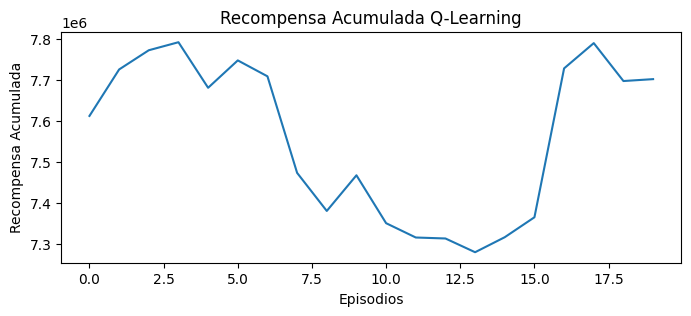

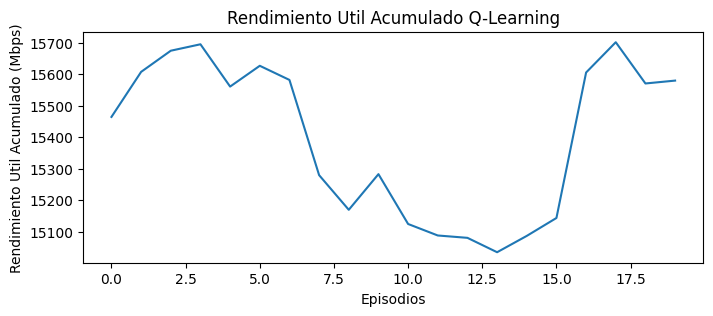

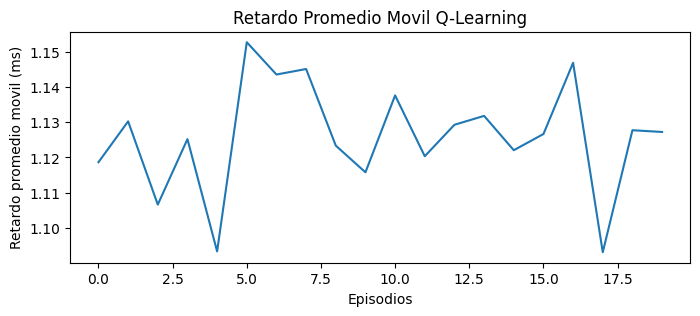

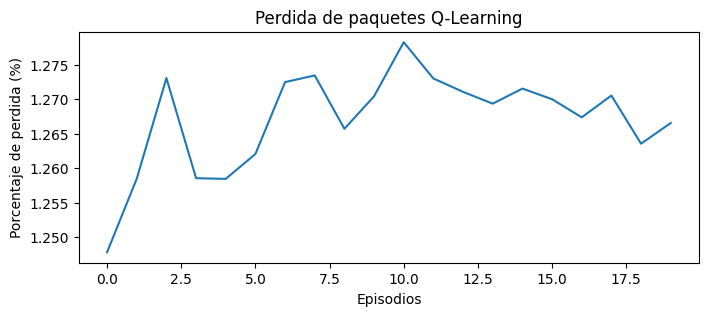

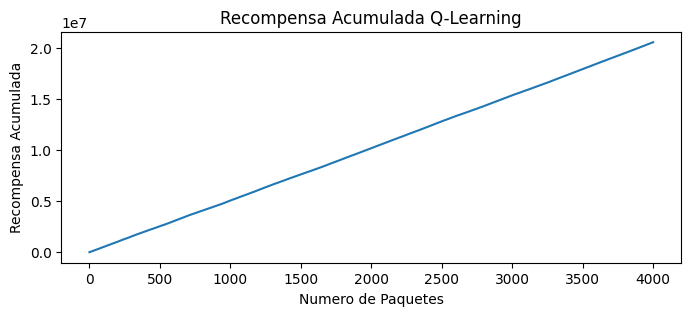

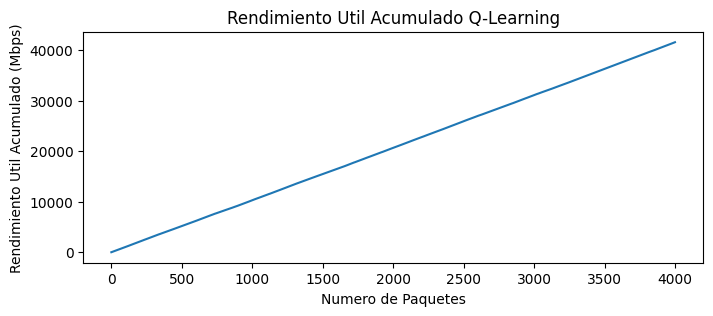

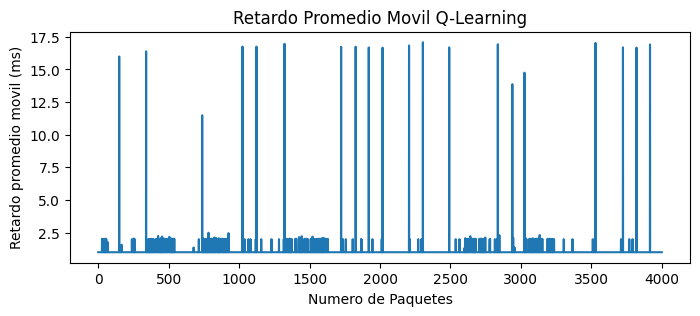

In [12]:
# Evaluacion
env = TactileInternetEnv(X_test_scaled)
episodes = 20

rewards = []
latencies = []
goodputs = []
losses = []

rewards_p = []
latencies_p = []
goodputs_p = []
total_reward_p = 0
total_goodput_p = 0

for episode in range(episodes):
    total_reward = 0
    total_latency = 0
    total_goodput = 0
    state = env.reset()
    state = discretize_state(state, state_bins)
    done = False
    while not done:
        action = np.argmax(Q[state])
        next_state, reward, done, info = env.step(action)
        next_state = discretize_state(next_state, state_bins)
        state = next_state

        total_reward += reward
        total_latency += info['latency']
        total_goodput += info['goodput']

        if len(rewards_p) < 4001:
            total_reward_p += reward
            total_goodput_p += info['goodput']
            rewards_p.append(total_reward_p)
            goodputs_p.append(total_goodput_p)
            latencies_p.append(info['latency'])


    print(f"Episodio: {episode}, Recompensa total: {total_reward:.3f}")

    rewards.append(total_reward)
    latencies.append(total_latency / env.current_step)
    goodputs.append(total_goodput)
    losses.append((env.packets_lost / env.packets_sent)*100)

# Calcular métricas promedio de evaluación
avg_total_reward = np.mean(rewards)
avg_total_goodput = np.mean(goodputs)
avg_total_losses = np.mean(losses)

delay_mobile_avg = sum(latencies[-10:]) / 10 if len(latencies) >= 10 else 0

print(f'Evaluación - Recompensa Promedio: {avg_total_reward:.3f}, Goodput Promedio: {avg_total_goodput:.3f}, Perdida paquetes: {avg_total_losses:.2f}, Retardo promedio movil: {delay_mobile_avg:.3f}')

rewards_ql_ev = rewards
latencies_ql_ev = latencies
goodputs_ql_ev = goodputs
losses_ql_ev = losses

episodes = range(len(rewards))

# Recompensa acumulada
plt.figure(figsize=(8, 3))
plt.plot(episodes, rewards)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Acumulada')
plt.title('Recompensa Acumulada Q-Learning')
plt.show()

# Goodput acumulado
plt.figure(figsize=(8, 3))
plt.plot(episodes, goodputs)
plt.xlabel('Episodios')
plt.ylabel('Rendimiento Util Acumulado (Mbps)')
plt.title('Rendimiento Util Acumulado Q-Learning')
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(episodes, latencies)
plt.xlabel('Episodios')
plt.ylabel('Retardo promedio movil (ms)')
plt.title('Retardo Promedio Movil Q-Learning')
plt.show()

# Perdida de paquetes
plt.figure(figsize=(8, 3))
plt.plot(episodes, losses)
plt.xlabel('Episodios')
plt.ylabel('Porcentaje de perdida (%)')
plt.title('Perdida de paquetes Q-Learning')
plt.show()


packets = range(len(rewards_p))
# Recompensa acumulada
plt.figure(figsize=(8, 3))
plt.plot(packets, rewards_p)
plt.xlabel('Numero de Paquetes')
plt.ylabel('Recompensa Acumulada')
plt.title('Recompensa Acumulada Q-Learning')
plt.show()

# Goodput acumulado
plt.figure(figsize=(8, 3))
plt.plot(packets, goodputs_p)
plt.xlabel('Numero de Paquetes')
plt.ylabel('Rendimiento Util Acumulado (Mbps)')
plt.title('Rendimiento Util Acumulado Q-Learning')
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(packets, latencies_p)
plt.xlabel('Numero de Paquetes')
plt.ylabel('Retardo promedio movil (ms)')
plt.title('Retardo Promedio Movil Q-Learning')
plt.show()

Implementación de DQN

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size, units=16, gamma=0.9, epsilon=1.0, learning_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.units = units
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = learning_rate
        self.step_count = 0
        
        # Buffer de experiencias
        self.memory_size = 2000
        self.memory = {
            'states': np.zeros((self.memory_size, state_size)),
            'actions': np.zeros(self.memory_size, dtype=np.int32),
            'rewards': np.zeros(self.memory_size),
            'next_states': np.zeros((self.memory_size, state_size)),
            'dones': np.zeros(self.memory_size, dtype=np.bool_)
        }
        self.memory_idx = 0
        self.batch_size = 32  # Tamaño de lote para entrenamiento
        
        self.model = self._build_model()  # Red neuronal principal
        self.target_model = self._build_model()  # Red neuronal objetivo
        self.update_target_model()  

    def _build_model(self):
        model = Sequential()
        model.add(Dense(self.units, input_dim=self.state_size))
        model.add(LeakyReLU(alpha=0.1))
        model.add(Dense(self.units))
        model.add(LeakyReLU(alpha=0.1)) 
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())  # Actualiza los pesos de la red objetivo con la principal
        
    def remember(self, state, action, reward, next_state, done):  
        # Almacena la transición en el buffer 
        idx = self.memory_idx % self.memory_size
        self.memory['states'][idx] = state
        self.memory['actions'][idx] = action
        self.memory['rewards'][idx] = reward
        self.memory['next_states'][idx] = next_state
        self.memory['dones'][idx] = done
        self.memory_idx += 1

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)  # Exploración
        
        state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
        action_probs = self.model(state_tensor) 
        return tf.argmax(action_probs[0]).numpy()  # Explotación

    def replay(self):
        if self.memory_idx < self.batch_size:
            return 0.0
            
        idx = np.random.choice(min(self.memory_idx, self.memory_size), self.batch_size, replace=False)

        # Extrae estados, acciones, recompensas y estados siguientes
        states = tf.convert_to_tensor(self.memory['states'][idx], dtype=tf.float32)
        actions = tf.convert_to_tensor(self.memory['actions'][idx], dtype=tf.int32)
        rewards = tf.convert_to_tensor(self.memory['rewards'][idx], dtype=tf.float32)
        next_states = tf.convert_to_tensor(self.memory['next_states'][idx], dtype=tf.float32)
        dones = tf.convert_to_tensor(self.memory['dones'][idx], dtype=tf.bool)

        # Cálculo de valores objetivo usando la red objetivo
        next_q_values = self.target_model(next_states)
        targets = rewards + self.gamma * tf.reduce_max(next_q_values, axis=1) * (1 - tf.cast(dones, tf.float32))

        # Ajuste del modelo usando gradientes
        with tf.GradientTape() as tape:
            q_values = self.model(states)
            action_masks = tf.one_hot(actions, self.action_size)
            q_action = tf.reduce_sum(q_values * action_masks, axis=1)
            loss = tf.reduce_mean(tf.square(targets - q_action))
            
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # Actualización de la red objetivo
        self.step_count += 1
        if self.step_count % 100 == 0:
            self.update_target_model()
            
        return loss.numpy()


def train_dqn(env, episodes=20):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    agent = DQNAgent(state_size, action_size, units=16, gamma=0.9, epsilon=1.0, learning_rate=0.01)
    
    rewards = []
    latencies = []
    goodputs = []
    losses = []

    start = 0
    end = 90 
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [state_size])
        total_reward = 0
        total_goodput = 0
        total_latency = 0
        episode_loss = 0
        steps = 0
        
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [state_size])
            
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            total_goodput += info['goodput']
            total_latency += info['latency']
            steps += 1
            
            loss = agent.replay()
            if loss:
                episode_loss += loss

            if steps < 3495 and start <= steps < end:
                rewards.append(total_reward)
                latencies.append(total_latency / steps if steps > 0 else 0)  # Latencia promedio hasta este paso
                goodputs.append(total_goodput)
                losses.append((env.packets_lost / env.packets_sent) * 100)
                start += 1

        start = start - 20
        end = end + 70
        if e % 5 == 0:
            print(f"Episodio: {e}, Recompensa: {np.mean(rewards):.2f}, Goodput:{np.mean(goodputs):.2f}, ε: {agent.epsilon:.3f}")

    return rewards, goodputs, losses, latencies

In [10]:
%%time
env = TactileInternetEnv(X_train_scaled)
rewards_dqn, goodputs_dqn, losses_dqn, latencies_dqn = train_dqn(env, 50)

avg_total_reward = np.mean(rewards_dqn)
avg_total_goodput = np.mean(goodputs_dqn)
avg_total_loss = np.mean(losses_dqn)

delay_mobile_avg = sum(latencies_dqn[-10:]) / 10 if len(latencies_dqn) >= 10 else 0

print(f'Evaluación - Recompensa Promedio: {avg_total_reward:.3f}, Goodput Promedio: {avg_total_goodput:.3f}, Perdida paquetes: {avg_total_loss:.2f}%,  Retardo promedio movil: {delay_mobile_avg:.3f}')

Episodio: 0, Recompensa: 233439.81, Goodput:470.20, ε: 0.010
Episodio: 5, Recompensa: 1119764.64, Goodput:2264.25, ε: 0.010
Episodio: 10, Recompensa: 2035694.15, Goodput:4100.75, ε: 0.010
Episodio: 15, Recompensa: 2951413.46, Goodput:5939.24, ε: 0.010
Episodio: 20, Recompensa: 3844492.12, Goodput:7741.63, ε: 0.010
Episodio: 25, Recompensa: 4756703.87, Goodput:9570.84, ε: 0.010
Episodio: 30, Recompensa: 5661410.38, Goodput:11389.36, ε: 0.010
Episodio: 35, Recompensa: 6570277.16, Goodput:13215.10, ε: 0.010
Episodio: 40, Recompensa: 7482057.73, Goodput:15046.19, ε: 0.010
Episodio: 45, Recompensa: 8395925.64, Goodput:16881.49, ε: 0.010
Evaluación - Recompensa Promedio: 9072710.613, Goodput Promedio: 18241.412, Perdida paquetes: 1.56%,  Retardo promedio movil: 1.202
CPU times: total: 30min 41s
Wall time: 30min 55s


In [11]:
# Métricas para los primeros 4000 paquetes
print(rewards_dqn[4000])
print(np.mean(rewards_dqn[:4000]))
print(np.mean(goodputs_dqn[:4000]))
print(np.mean(losses_dqn[:4000]))

latencies_dqn_1 = latencies_dqn[:4000]
delay_mobile_avg = sum(latencies_dqn_1[-10:]) / 10 if len(latencies_dqn_1) >= 10 else 0
print(delay_mobile_avg)

16179133.027158016
8111051.295133802
16309.169940729964
1.5608056786091373
1.211236220597102


Implementación de A2C

In [17]:
# Definición del entorno para la acción continua
class CTactileInternetEnv(gym.Env):
    def __init__(self, data):
        super(CTactileInternetEnv, self).__init__()
        self.data = np.array(data, dtype=np.float32)
        self.current_step = 0
        self.state = None
        self.packets_sent = 0
        self.packets_lost = 0

        # Parámetros de codificación RLNC
        self.coefficients = 3
        self.generation_size = 3 

        # Rango de normalización para cada parámetro
        self.num_segments_range = (1, 10)  # Número de segmentos (1 a 10)
        self.error_rate_range = (0, 0.5)   # Tasa de error (0% a 50%)
        self.bandwidth_range = (100, 500)  # Ancho de banda (100 Mbps a 500 Mbps)
        self.cong_index_range = (0, 1) 


        self.action_space = spaces.Box(
            low=-2.0, 
            high=2.0, 
            shape=(1,),  # 1 acción continua
            dtype=np.float32
        )
        self.observation_space = spaces.Box(low=0, high=1, shape=(data.shape[1],), dtype=np.float32)
        self.reset()

    def reset(self):
        self.current_step = 0
        self.received_packets = []    
        self.decoded = False
        self.state = self.data[self.current_step]
        return self.state

    def desnormalize(self, value, value_range):
        # Convierte un valor normalizado [0,1] a su escala original
        return value_range[0] + value * (value_range[1] - value_range[0])

    def rlnc_encode(self, data, num_coefficients):
        # Codifica los datos usando RLNC
        coefficients = np.random.rand(num_coefficients) 
        coefficients = coefficients / np.sum(coefficients) 
        encoded_packet = np.sum([c * d for c, d in zip(coefficients, data)], axis=0) 
        return coefficients, encoded_packet    # Devuelve los coeficientes y el paquete codificado

    def rlnc_decode(self):
        # Intenta reconstruir los datos originales resolviendo un sistema lineal
        if len(self.received_packets) < self.generation_size: 
            return False 
        try:
            A = []
            b = []
            for coeffs, packet in self.received_packets[:self.generation_size]:
                A.append(coeffs)   
                b.append(packet[0])  
            # Resolver sistema lineal
            A = np.array(A) 
            b = np.array(b)  
            decoded = np.linalg.solve(A, b)   
            return True  
        except np.linalg.LinAlgError:
            return False

    def simulate_lost_packet(self, cong_index, rate_bd):
        # Simula la pérdida de paquetes
        self.packets_sent += 1
        probability_loss = 0.8 
        if probability_loss < random.random() and cong_index > rate_bd :
            self.packets_lost += 1
            return False
        return True

    def simulate_packet_transfer(self, state, num_segments):
        # Simula el envío de paquetes codificados y calcula las métricas de red
        bandwidth, cong_index, error_rate = state[:-1]
        packet_size_bytes = 1500  
        packet_size_bits = packet_size_bytes * 8 
        latency = 0.0
        tpD = 0.001
        
        num_segments = int(num_segments)
        error_rate = self.desnormalize(error_rate, self.error_rate_range)
        bandwidth = self.desnormalize(bandwidth, self.bandwidth_range)
        bandwidth_bps = bandwidth * 1e6  # Mbps en bits/segundo

        start = time.time()

        rate_bd = ( bandwidth/num_segments) / 100

        original_data = [np.random.rand(10) for _ in range(self.generation_size)] 
        
        # Codificación RLNC
        encoded_packets = []
        for _ in range(num_segments):
            coeffs, encoded = self.rlnc_encode(original_data, self.coefficients)
            encoded_packets.append((coeffs, encoded))
        
        # Simular envío y recepción
        for packet in encoded_packets:
            packet_sent = self.simulate_lost_packet(cong_index, rate_bd)
            if packet_sent:  
                self.received_packets.append(packet)

        # Decodificar
        self.decoded = self.rlnc_decode()

        if packet_sent:
            latency = time.time() - start + tpD  
        else:
            latency = time.time() - start + tpD * 2  # Castigo por retransmisión 
            self.packets_sent += 1
                
        # Cálculo del Goodput (datos útiles entregados por segundo)
        goodput_bps =  packet_size_bits * (1 - error_rate) / latency if latency > 0 else 0
        goodput_mbps = goodput_bps / 1e6
        goodput_mbps = min(goodput_mbps, bandwidth * (1 - error_rate))
    
        return latency, goodput_mbps

    def step(self, action):
        num_segments = self.desnormalize(self.state[3], self.num_segments_range)

        # Acción continua:
        # - action > 0: aumentar segmentos
        # - action < 0: reducir segmentos
        delta = action[0]
    
        # Modifica el número de segmentos según la acción manteniendo los límites
        new_segments = np.clip(
            num_segments + delta,
            self.num_segments_range[0],
            self.num_segments_range[1]
        )
        new_segments = int(round(new_segments))

        self.state[3] = (new_segments - self.num_segments_range[0]) / (self.num_segments_range[1] - self.num_segments_range[0])

        # Aplica la acción y calcula la recompensa
        latency, goodput = self.simulate_packet_transfer(self.state, new_segments)

        reward = goodput/(2*latency)

        self.current_step += 1
        done = self.current_step >= len(self.data) - 1
        next_state = self.data[self.current_step] if not done else np.zeros(self.observation_space.shape)

        self.state = next_state

        return next_state, reward, done, {'goodput': goodput, 'latency': latency*1000}

    def render(self, mode='human'):
        print(f'Step: {self.current_step}')

In [18]:
# Modelo Actor-Critico
class ContinuousA2C(tf.keras.Model):
    def __init__(self, action_dim):
        super(ContinuousA2C, self).__init__()
        self.action_dim = action_dim
        
        # Red actor
        self.actor_fc1 = Dense(64, activation='relu')
        self.actor_fc2 = Dense(64, activation='relu')
        self.actor_mu = Dense(action_dim)  
        self.actor_sigma = Dense(action_dim, activation='softplus')  
        
        # Red critico
        self.critic_fc1 = Dense(64, activation='relu')
        self.critic_fc2 = Dense(64, activation='relu')
        self.critic_out = Dense(1)

    def call(self, state):
        # Actor
        x = self.actor_fc1(state)
        x = self.actor_fc2(x)
        mu = self.actor_mu(x)
        sigma = self.actor_sigma(x) + 1e-5  
        
        # Critico
        y = self.critic_fc1(state)
        y = self.critic_fc2(y)
        value = self.critic_out(y)
        
        return mu, sigma, value

# Agente A2C
class ContinuousA2CAgent:
    def __init__(self, env, model, gamma=0.99, lr=0.001, entropy_coef=0.01):
        self.env = env
        self.model = model
        self.gamma = gamma                # Factor de descuento
        self.entropy_coef = entropy_coef  # Coeficiente para regularización por entropía
        self.optimizer = Adam(learning_rate=lr)
    
    def sample_action(self, state):
        state = np.expand_dims(state, axis=0)
        mu, sigma, _ = self.model(state)
        
        # Selección de la acción con distribución Gaussiana
        action = np.random.normal(mu.numpy()[0], sigma.numpy()[0])
        
        action = np.clip(action, self.env.action_space.low, self.env.action_space.high)
        
        return action, mu.numpy()[0], sigma.numpy()[0]
    
    def compute_entropy(self, sigma):
        # Cálculo de la entropía
        return 0.5 * (tf.math.log(2 * np.pi * sigma**2) + 1)
    
    def train_step(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, axis=0)
        next_state = np.expand_dims(next_state, axis=0)
        
        with tf.GradientTape() as tape:
            mu, sigma, value = self.model(state)
            _, _, next_value = self.model(next_state)
            
            # Cálculo de la ventaja
            delta = reward + self.gamma * next_value * (1 - int(done)) - value
            advantage = delta 

            # Perdida del actor
            log_prob = -0.5 * tf.reduce_sum(((action - mu) / sigma)**2) - tf.reduce_sum(tf.math.log(sigma))
            actor_loss = -log_prob * advantage

            # Regularización por entropía para fomentar la exploración
            entropy = self.compute_entropy(sigma)
            entropy_loss = -self.entropy_coef * tf.reduce_mean(entropy)
            
            # Pérdida del crítico
            critic_loss = tf.reduce_sum(tf.square(delta))
            
            total_loss = actor_loss + critic_loss + entropy_loss
        
        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        return total_loss.numpy()

    def train(self, num_episodes):
        rewards = []
        goodputs = []
        losses = []
        latencies = []

        # Ventana de recolección de métricas
        start = 0
        end = 110
        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            total_goodput = 0
            total_latency = 0
            steps = 0
            done = False
            
            while not done:
                action, mu, sigma = self.sample_action(state)
        
                next_state, reward, done, info = env.step(action)

                # Actualización del modelo
                loss = self.train_step(state, action, reward, next_state, done)

                total_reward += reward
                total_goodput += info['goodput']
                total_latency += info['latency']
                steps += 1
                
                state = next_state

                if steps < 3495 and start <= steps < end:
                    rewards.append(total_reward)
                    latencies.append(total_latency / steps if steps > 0 else 0)
                    goodputs.append(total_goodput)
                    losses.append((env.packets_lost / env.packets_sent) * 100)
                    start += 1

                if done:
                    break

            start = start - 20
            end = end + 90

            print(f"Episodio: {episode + 1}, Recompensa: {total_reward}, Goodput: {total_goodput}, Latency: {total_latency / (steps)}")

        return rewards, goodputs, losses, latencies


  

In [20]:
%%time
env = CTactileInternetEnv(X_train_scaled)
model = ContinuousA2C(action_dim=env.action_space.shape[0])
agent = ContinuousA2CAgent(env, model)

model = ContinuousA2C(action_dim=1)  # 1 acción continua
agent = ContinuousA2CAgent(env, model)

# Entrenar el modelo
rewards_a2c, goodputs_a2c, losses_a2c, latencies_a2c = agent.train(num_episodes=40)


Episodio: 1, Recompensa: 18134606.627194904, Goodput: 36545.14695910681, Latency: 1.0695871412072084
Episodio: 2, Recompensa: 18378361.452915132, Goodput: 36874.314752651364, Latency: 1.0498211711167744
Episodio: 3, Recompensa: 18419438.874747485, Goodput: 36932.35814730556, Latency: 1.0455346036557476
Episodio: 4, Recompensa: 18459116.64537479, Goodput: 36989.6551716442, Latency: 1.0234659618316582
Episodio: 5, Recompensa: 18523572.035071, Goodput: 37079.0888774287, Latency: 1.0260399266293174
Episodio: 6, Recompensa: 18542598.724404804, Goodput: 37112.38828228155, Latency: 1.0124794192936108
Episodio: 7, Recompensa: 18451245.99445039, Goodput: 36957.79293973479, Latency: 1.0648233928724067
Episodio: 8, Recompensa: 18498429.580236997, Goodput: 37033.18598352759, Latency: 1.0409949016789277
Episodio: 9, Recompensa: 18530426.82898865, Goodput: 37085.33837378916, Latency: 1.027098290161901
Episodio: 10, Recompensa: 18454635.433072507, Goodput: 36951.54469564199, Latency: 1.07606132352379

In [21]:
avg_total_reward = np.mean(rewards_a2c)
avg_total_goodput = np.mean(goodputs_a2c)
avg_losses = np.mean(losses_a2c)

delay_mobile_avg = sum(latencies_a2c[-10:]) / 10 if len(latencies_a2c) >= 10 else 0

print(f'Evaluación - Recompensa Promedio: {avg_total_reward:.3f}, Goodput Promedio: {avg_total_goodput:.3f}, perdida paquetes: {avg_losses:.3f}, Retardo promedio movil: {delay_mobile_avg:.3f}')


Evaluación - Recompensa Promedio: 9266210.363, Goodput Promedio: 18570.958, perdida paquetes: 0.701, Retardo promedio movil: 1.050


In [22]:
# Métricas para los primeros 4000 paquetes
print(rewards_a2c[4000])
print(np.mean(rewards_a2c[:4000]))
print(np.mean(goodputs_a2c[:4000]))
print(np.mean(losses_a2c[:4000]))

latencies_a2c_1 = latencies_a2c[:4000]
delay_mobile_avg = sum(latencies_a2c_1[-10:]) / 10 if len(latencies_a2c_1) >= 10 else 0
print(delay_mobile_avg)

17220165.671714716
8681810.778718643
17393.995585015655
0.723936485882849
1.0412545136415112


# Gráficas

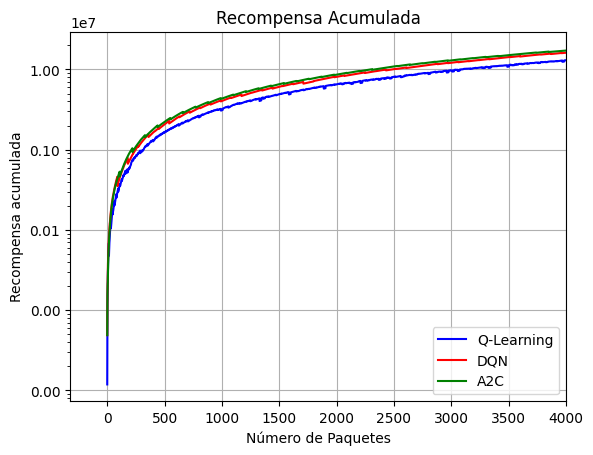

In [23]:
# Recompensa Acumulada
plt.plot(rewards_ql, label='Q-Learning', color='blue') 
plt.plot(rewards_dqn, label='DQN', color='red')  
plt.plot(rewards_a2c, label='A2C', color='green')   
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter()) 
plt.title('Recompensa Acumulada')
plt.xlabel('Número de Paquetes')
plt.ylabel('Recompensa acumulada')
plt.legend() 
plt.grid(True)  
plt.xlim(None, 4000)
plt.show()

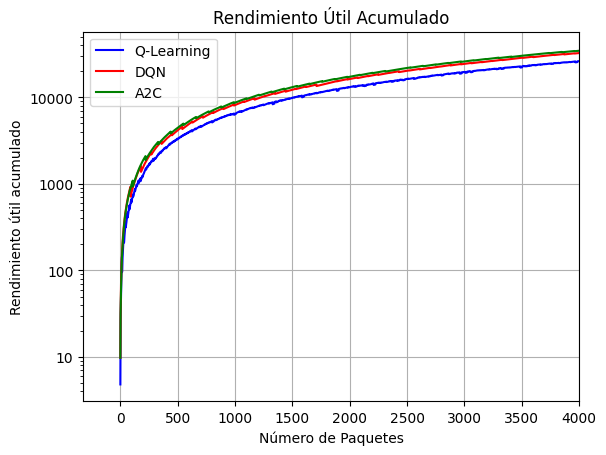

In [24]:
#Rendimiento Util Acumulado
plt.plot(goodputs_ql, label='Q-Learning', color='blue')  
plt.plot(goodputs_dqn, label='DQN', color='red')  
plt.plot(goodputs_a2c, label='A2C', color='green') 
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())  
plt.title('Rendimiento Útil Acumulado')
plt.xlabel('Número de Paquetes')
plt.ylabel('Rendimiento útil acumulado')
plt.legend()  
plt.grid(True)

plt.xlim(None, 4000)
plt.show()

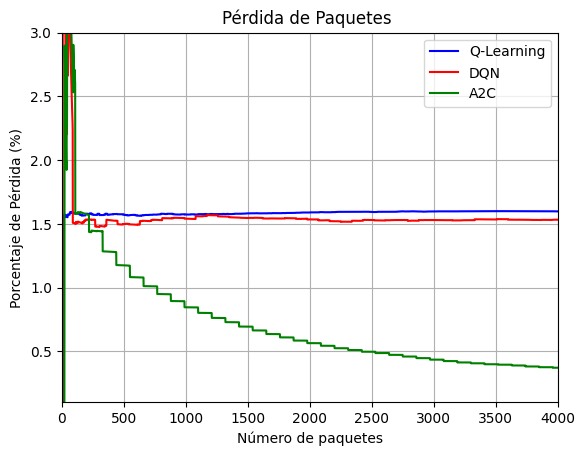

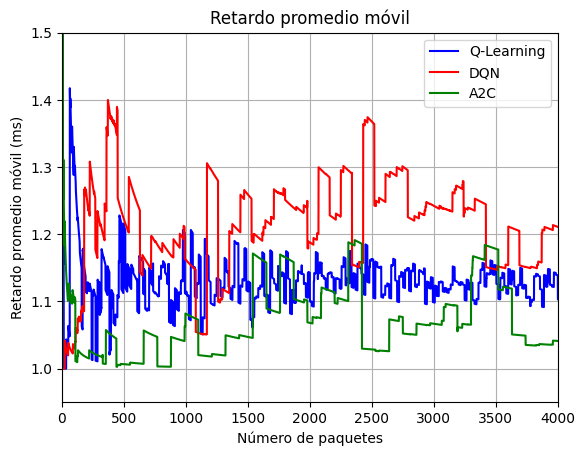

In [26]:
# Perdida de Paquetes
plt.plot(losses_ql, label='Q-Learning', color='blue')  
plt.plot(losses_dqn, label='DQN', color='red')  
plt.plot(losses_a2c, label='A2C', color='green')   
plt.title('Pérdida de Paquetes ')
plt.xlabel('Número de paquetes')
plt.ylabel('Porcentaje de Pérdida (%)')
plt.legend()  
plt.grid(True)

plt.xlim(0, 4000)  
plt.ylim(0.1, 3.0) 
plt.show()

# Retardo promedio movil
plt.plot(latencies_ql, label='Q-Learning', color='blue')  
plt.plot(latencies_dqn, label='DQN', color='red')  
plt.plot(latencies_a2c, label='A2C', color='green')   
plt.title('Retardo promedio móvil')
plt.xlabel('Número de paquetes')
plt.ylabel('Retardo promedio móvil (ms)')
plt.legend()  
plt.grid(True)

plt.xlim(0, 4000)  
plt.ylim(0.95, 1.5) 
plt.show()
